In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import shapely
from collections import Counter
from xgboost import XGBClassifier
from xgboost import callback
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import libpysal
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        print(filename)
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [3]:
df17 = load_data(2017)
df18 = load_data(2018)
wt = libpysal.weights.DistanceBand.from_dataframe(df17, threshold=150, binary = True, silence_warnings = True)
wv = libpysal.weights.DistanceBand.from_dataframe(df18, threshold=150, binary = True, silence_warnings = True)

eindhoven17.csv_filled_.csv
eindhoven18.csv_filled_.csv


In [4]:

scaler = StandardScaler()
X17 = df17[df17.columns[:-4]]
Y17 = df17.y

X18 = df18[df18.columns[:-4]]
Y18 = df18.y

X17 = pd.DataFrame(scaler.fit_transform(X17))
X18 = pd.DataFrame(scaler.transform(X18))

In [5]:
def cluster_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    X_tot = {}
    Y_tot = {}
    for filename in os.listdir(path):
        
        df1 = pd.read_csv(path + filename)
        X17 = df1[df17.columns[:-4]]
        X17 = pd.DataFrame(scaler.fit_transform(X17))
        
        x = []
        y = []
        for c in [2,3,4,5,6,7,8, 9, 10,11]:
            kmeans_model = KMeans(n_clusters=c, random_state=1).fit(X17)
            labels = kmeans_model.labels_
            y.append(metrics.silhouette_score(X17, labels, metric='euclidean'))
            x.append(c)
        
        X_tot[filename] = x
        Y_tot[filename] = y
        

    return X_tot, Y_tot


In [10]:
x,y = cluster_data(2017)

In [11]:
plt.style.use("ggplot")

In [12]:
x

{"'s-Gravenhage17.csv_filled_.csv": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'eindhoven17.csv_filled_.csv': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'Nijmegen17.csv_filled_.csv': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

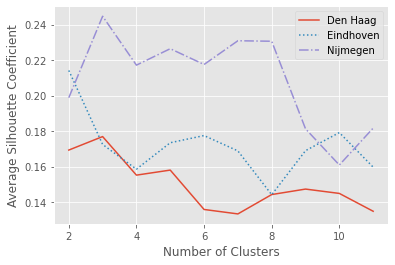

In [17]:
keys = list(x.keys())
plt.plot(x[keys[0]], y[keys[0]], label = "Den Haag", linestyle = "-")
plt.plot(x[keys[1]], y[keys[1]], label = "Eindhoven", linestyle = "dotted")
plt.plot(x[keys[2]], y[keys[2]], label = "Nijmegen", linestyle = "-.")
plt.ylabel("Average Silhouette Coefficient")
plt.xlabel("Number of Clusters")
plt.legend()

plt.savefig("../figures/ClustersSilhouette.png")

In [14]:
def cluster_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    dfs = {}
    for filename in os.listdir(path):
        if "hage" in filename:
            c = 3
            name = "DH"
        elif "ijm" in filename:
            c = 3
            name = "NM"
        else:
            c = 2
            name = "EH"
        print(filename, c)  
        df = pd.read_csv(path + filename)
        X17 = df[df17.columns[:-5]]
        X17 = pd.DataFrame(scaler.fit_transform(X17))
        

        kmeans_model = KMeans(n_clusters=c, random_state=1).fit(X17)
        labels = kmeans_model.labels_
        df = gpd.GeoDataFrame(df)
        df.geometry = df.geometry.apply(shapely.wkt.loads)

        df["label"] = labels
        dfs[name] = df
        
    return dfs

In [15]:
a = cluster_data(2017)

's-Gravenhage17.csv_filled_.csv 3
eindhoven17.csv_filled_.csv 2
Nijmegen17.csv_filled_.csv 3


# plot city with Y

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


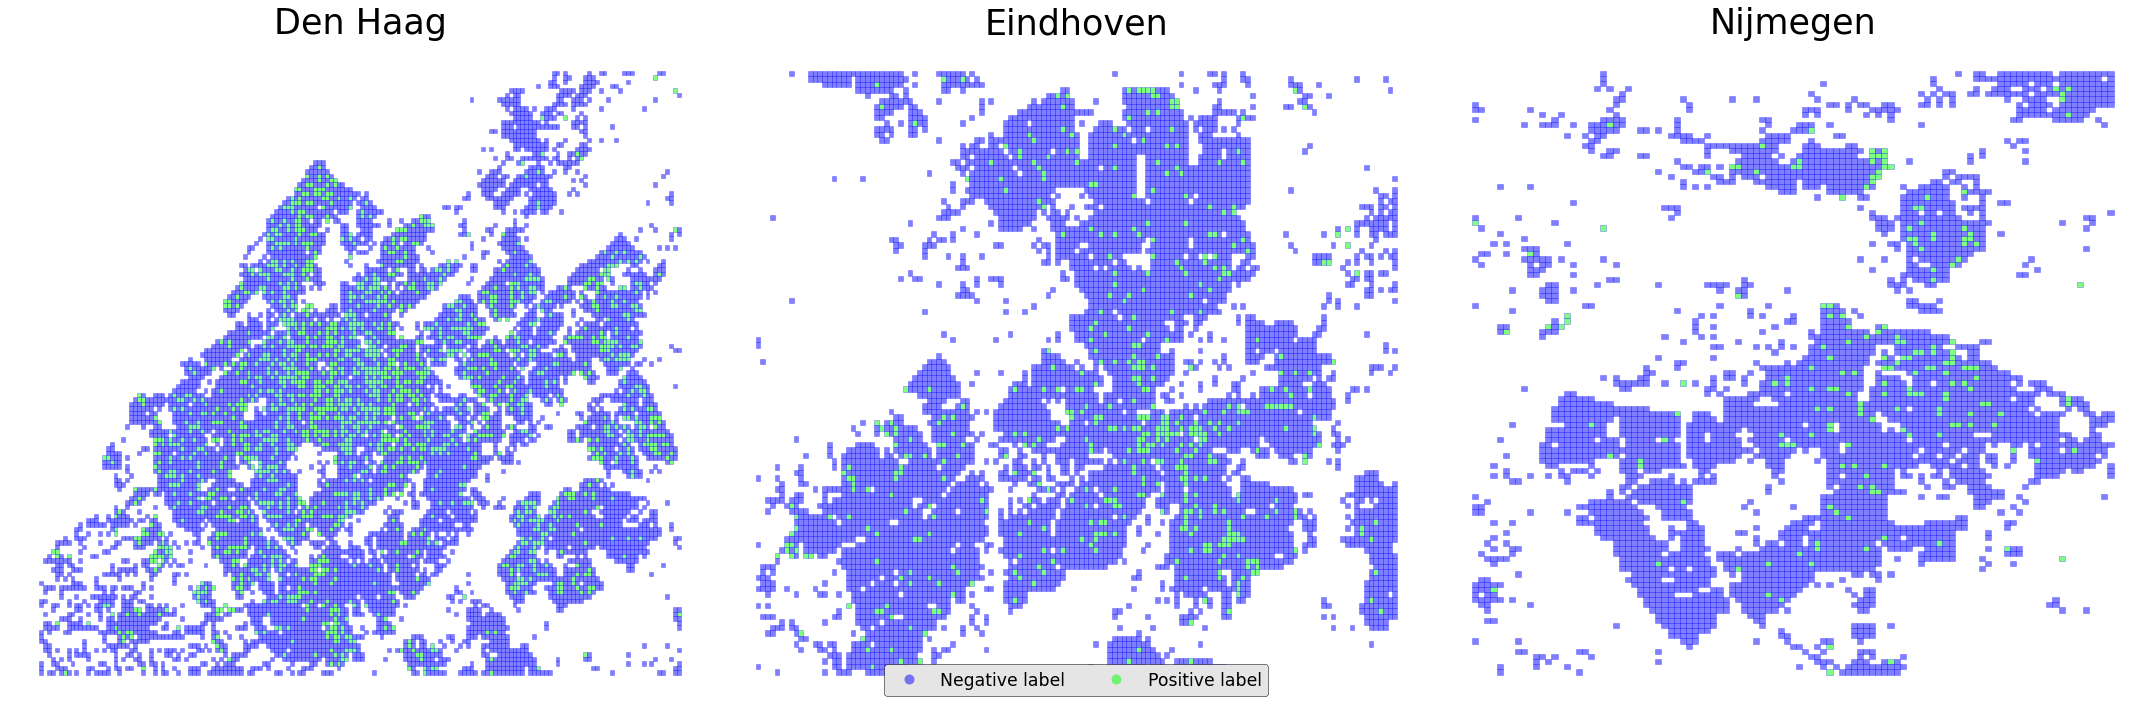

In [36]:
fig, ax = plt.subplots(1,3, figsize = (30,10))
print(ax)
a["DH"].plot(column = "y", cmap = "brg", ax = ax[0], categorical = True, alpha=0.5, edgecolor = "b")

b = a["EH"].plot(column = "y", cmap = "brg", ax = ax[1], categorical = True, alpha=0.5, edgecolor = "b", legend=True, 
                 legend_kwds={"frameon" : True, "edgecolor":"black","prop":{"size":"xx-large"},
                             "fancybox" : True,'loc': 'lower center', "framealpha" : 1, "ncol":2})
a["NM"].plot(column = "y", cmap = "brg", ax = ax[2], categorical = True, alpha=0.5, edgecolor = "b")

ax[0].set_title("Den Haag", size = 35)
ax[1].set_title("Eindhoven", size = 35)
ax[2].set_title("Nijmegen", size = 35)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')

mapper = {0.0: "Negative label", 1.0: "Positive label"}

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
                
                
legend = ax[1].get_legend()             
replace_legend_items(legend, mapper)
plt.tight_layout()
plt.savefig("../figures/steden.png")

# Plot city with clusters

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


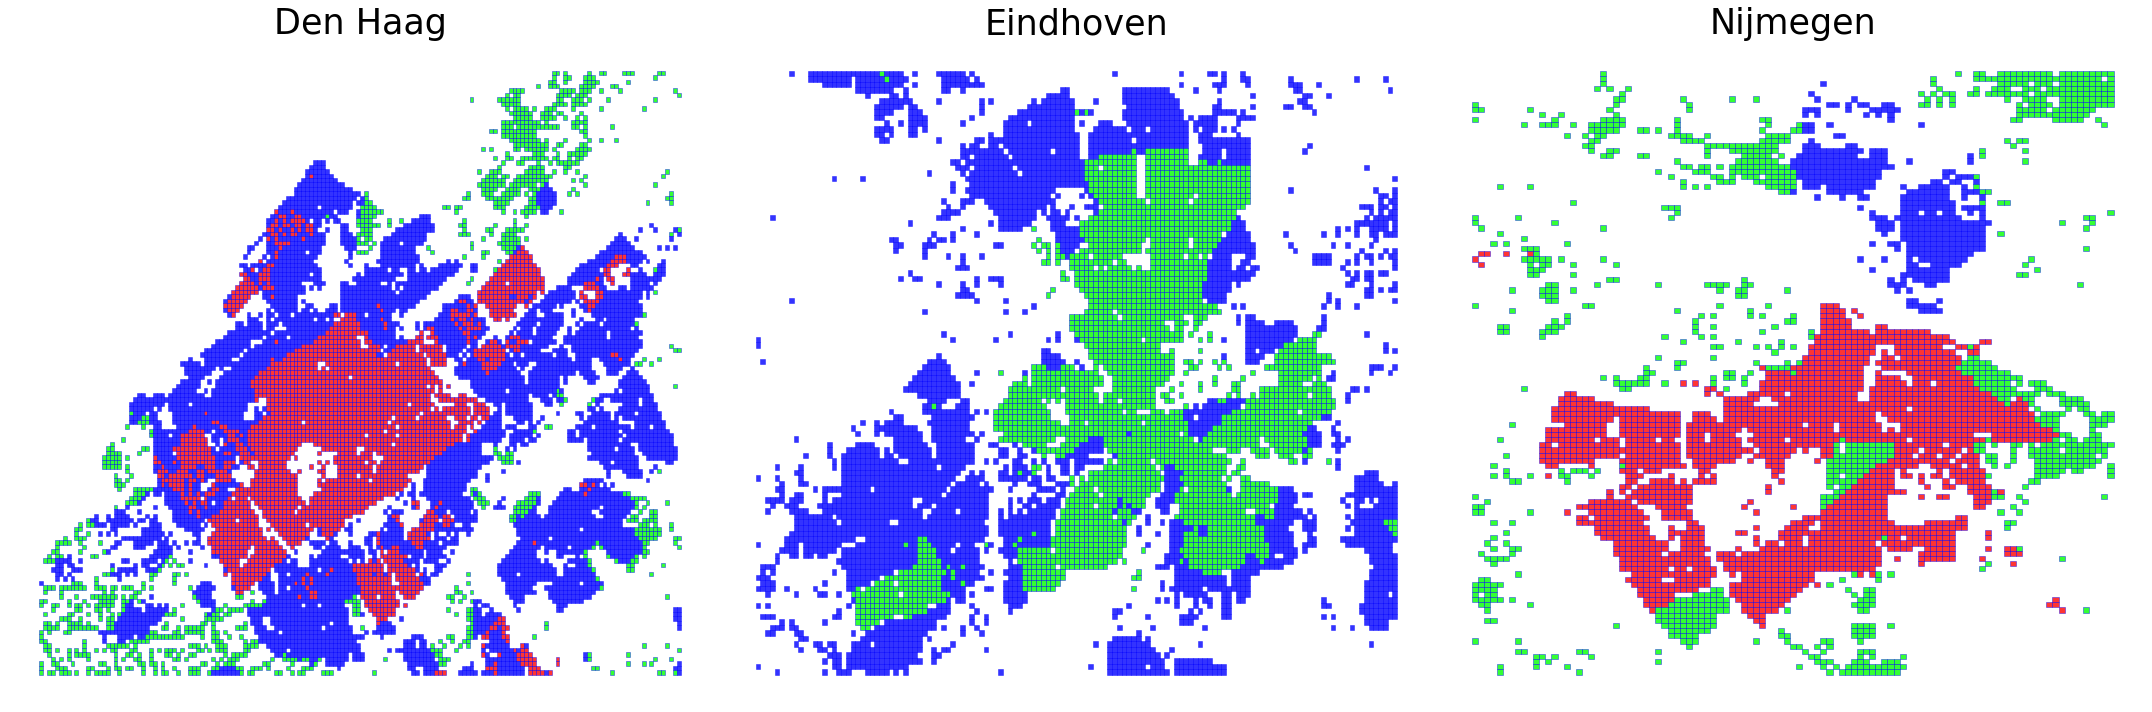

In [25]:
fig, ax = plt.subplots(1,3, figsize = (30,10))
print(ax)
b = a["DH"].plot(column = "label", cmap = "brg", ax = ax[0], categorical = True, alpha=0.8, edgecolor = "b")
a["EH"].plot(column = "label", cmap = "brg", ax = ax[1], categorical = True, alpha=0.8, edgecolor = "b")
a["NM"].plot(column = "label", cmap = "brg", ax = ax[2], categorical = True, alpha=0.8, edgecolor = "b")

ax[0].set_title("Den Haag", size = 35)
ax[1].set_title("Eindhoven", fontsize = 35)
ax[2].set_title("Nijmegen", fontsize = 35)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')
plt.tight_layout()
plt.savefig("../figures/Citiesclustered.png")

In [320]:
def Yratio(years):
    os.getcwd()
    zeven = []
    acht = []
    negen = []
    for i, year in enumerate(years):
        path = "../Data/filled/" + str(year) + "/"
        for filename in os.listdir(path):
            print(filename)
            df = pd.read_csv(path + filename)
            if i == 0: zeven.append((df["y"] == 1).sum() / df.shape[0])
            elif i == 1: acht.append((df["y"] == 1).sum() / df.shape[0])
            else: negen.append((df["y"] == 1).sum() / df.shape[0])

            
    return {17: zeven, 18 : acht, 19 : negen}

In [321]:
ratios = Yratio([2017, 2018, 2019])

's-Gravenhage17.csv_filled_.csv
eindhoven17.csv_filled_.csv
Nijmegen17.csv_filled_.csv
's-Gravenhage18.csv_filled_.csv
eindhoven18.csv_filled_.csv
Nijmegen18.csv_filled_.csv
's-Gravenhage19.csv_filled_.csv
eindhoven19.csv_filled_.csv
Nijmegen19.csv_filled_.csv


In [322]:
ratios

{17: [0.21800842758926592, 0.08043197936814958, 0.052442727021805136],
 18: [0.1769289869388651, 0.07651672802945414, 0.06006582556226001],
 19: [0.22184709213678938, 0.08535795270489148, 0.1089377886443901]}

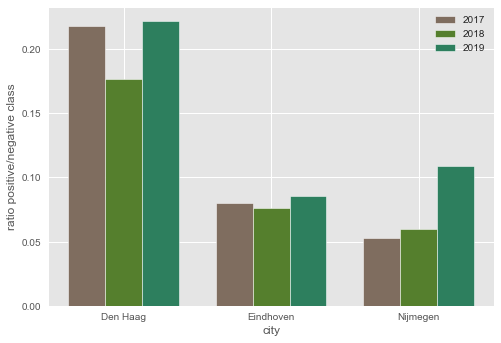

In [333]:
fig, ax = plt.subplots()
barWidth = 0.25
r1 = np.arange(len(ratios[17]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, ratios[17], color='#7f6d5f', width=barWidth, edgecolor='white', label='2017')
plt.bar(r2, ratios[18], color='#557f2d', width=barWidth, edgecolor='white', label='2018')
plt.bar(r3, ratios[19], color='#2d7f5e', width=barWidth, edgecolor='white', label='2019')



plt.xlabel('city')
plt.xticks([r + barWidth for r in range(len(ratios[17]))], ["Den Haag", "Eindhoven", "Nijmegen"])
plt.ylabel("ratio positive/negative class")
plt.legend()
plt.savefig("../figures/distributions.png")


In [ ]:
mapper = {0.0: "Negative label", 1.0: "Positive label"}

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
                
                
legend = ax[2].get_legend()             
replace_legend_items(legend, mapper)

TypeError: 'Legend' object is not callable